This notebooks builds a simulated dataset with population covariance structure

In [29]:
import numpy as np
import seaborn as sns
import pandas as pd
import random, string

In [30]:
#Fill the lower diagonal of a matrix using an array input a
def fill_lower_diag(a):
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1)
    out = np.zeros((n,n),dtype=np.float64)
    out[mask] = a
    return out

#Randomly assign gender with probability 
def random_gender(x,p=0.5):
    coin = np.random.rand()
    if coin > p:
        return 'female'
    else: 
        return 'male'

In [31]:
#Sampling Parameters
#Number of samples in each group
n = 200
samps = 2*n

#Column names for renaming
cols = ['rt','brain_vol','brain_sa','brain_gm_thick','se','e','cog','group']

In [32]:
#Control Covariance Matrix lower triangular
dx_control = np.array([0, 
                      0.1, 0.5,
                      0.6, 0.6, 0.1, 
                      0.03, 0.1, 0, 0,
                      0.05, 0, 0, 0, 0.7,
                      0.7, 0.05, 0.15, 0.1, 0.2, 0])

#Case covariance matrix lower triangular
dx_case = np.array([0, 
                  0.1, 0.5,
                  0.6, 0.6, 0.1, 
                  0.03, 0.1, 0, 0,
                  0.05, 0, 0, 0, 0.7,
                  0.0, 0.05, -0.25, 0.1, 0.2, 0])

In [33]:
#Make full covariance matrix and sample from multivariate Z-distribution
lower_control = fill_lower_diag(dx_control)
corr_control = lower_control + lower_control.T
d = corr_control.shape[0]
mu = np.zeros((d,))
np.fill_diagonal(corr_control,1)
control_X = np.random.multivariate_normal(mu, corr_control,size=n)

lower_case = fill_lower_diag(dx_case)
corr_case = lower_case + lower_case.T
np.fill_diagonal(corr_case,1)
case_X = np.random.multivariate_normal(mu, corr_case, size=n)

In [34]:
#Set up dataframes for case control then stack
control_df = pd.DataFrame(control_X)
control_df['diagnosis'] = 'control'
case_df = pd.DataFrame(case_X)
case_df['diagnosis'] = 'case'
df = pd.concat([control_df,case_df]).reset_index(drop=True)
df.columns = cols
df['gender'] = df.apply(random_gender,axis=1)

In [35]:
#Make random subject IDs using alphanumeric characters
not_unique = True
while not_unique:
    x = [''.join(random.choices(string.ascii_letters + string.digits, k=16)) for i in np.arange(samps)]
    
    if np.unique(x).shape[0] == samps:
        not_unique = False
        
df['subject_id'] = x

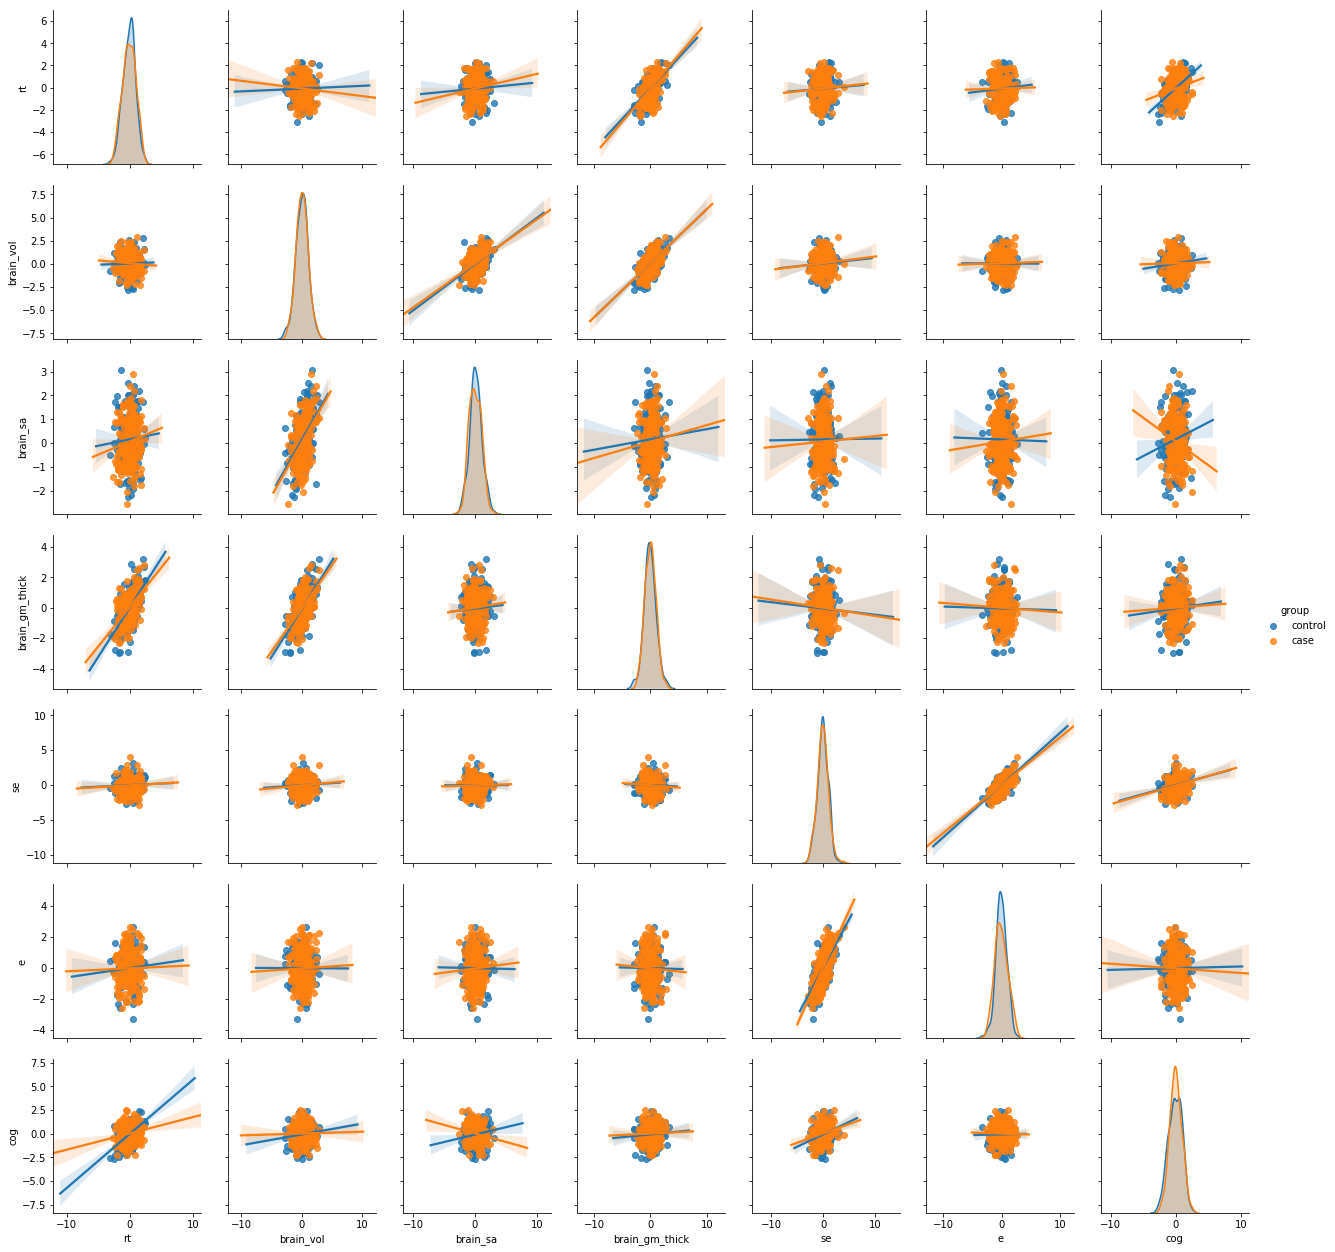

In [36]:
#View correlation plot
sns.pairplot(df,kind='reg',hue='group')

In [37]:
df.head()

,rt,brain_vol,brain_sa,brain_gm_thick,se,e,cog,group,gender,subject_id
0,1.376868,-0.322514,-0.843909,1.560168,-0.278185,0.231575,-0.145168,control,male,p7U1juxknprs2w5C
1,-1.580878,-0.021242,0.767791,-1.076180,0.338263,0.817527,-1.002859,control,male,nd2Y3hGWKQVSHj75
2,0.061918,-1.610395,0.107657,-1.066330,0.023205,-0.774354,0.162122,control,female,yiMrzXHoelyY7EJM
3,0.044595,-0.416836,0.814594,0.179360,-1.980643,-1.279318,-0.531776,control,female,7Tm46aoyg0a7aSBV
4,-0.446537,0.277720,-0.610138,0.007719,1.659108,1.839727,0.109909,control,male,uoI3YX4pk5jx398v


In [38]:
#set up masks
control_mask = df['group'] == 'control'
case_mask = df['group'] == 'case'
male_mask = df['gender'] == 'male'
female_mask = df['gender'] == 'female'

Setting up Reaction Time distributions:

Reaction Time distributions should have a mean effect across groups. For an inhibition type task the following effects are desired:

1. Case vs Control effect
2. Interaction effect already encoded in covariance model

Assume variance is fixed across both populations

In [39]:
#Set parameters
rt_var = 50
mu_rt_control = 720 + np.random.randn()*5
mu_rt_case = 910 + np.random.randn()*5
df.loc[control_mask,'rt'] = df[control_mask]['rt']*rt_var + mu_rt_control
df.loc[case_mask,'rt'] = df[case_mask]['rt']*rt_var + mu_rt_case

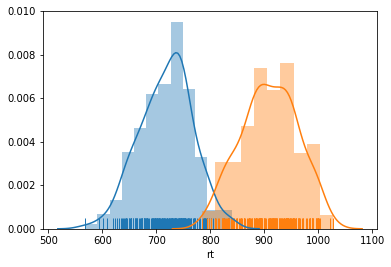

In [40]:
sns.distplot(df[ df['group'] == 'control']['rt'],rug=True)
sns.distplot(df[ df['group'] == 'case']['rt'], rug=True)

Setting up Brain Volume distributions
1. Case vs Control no effect
2. Gender effect (mean)

Assume fixed variance across genders

In [41]:
bv_var = 100
bv_male_mu = 1260 + np.random.randn()*30
bv_female_mu = 1130 + np.random.randn()*30
df.loc[male_mask,'brain_vol'] = df[male_mask]['brain_vol']*bv_var + bv_male_mu
df.loc[female_mask,'brain_vol'] = df[female_mask]['brain_vol']*bv_var + bv_female_mu

Setting up brain surface area distributions:
Male and female are identical, case and control are identical

In [42]:
bsa_mu = 1750 + np.random.randn()*20
bsa_var = 100
df['brain_sa'] = df['brain_sa']*bsa_var + bsa_mu

Setting up brain cortical thickness distributions:
1. Case vs Control effect
2. No male vs female effect

In [43]:
bt_var = 1
bt_case_mu = 3 + np.random.randn()*0.5
bt_control_mu = 5 + np.random.randn()*0.5
df.loc[control_mask,'brain_gm_thick'] = df[control_mask]['brain_gm_thick']*bt_var + bt_control_mu
df.loc[case_mask,'brain_gm_thick'] = df[case_mask]['brain_gm_thick']*bt_var + bt_case_mu

Socioeconomic status:

1. Socioeconomic status has a mean difference in case vs control
2. Socioeconomic status has no difference between males and female

We can say that it is derived from a bunch of other measures including education and summed up

In [44]:
se_var = 1
se_case_mu = 10 + np.random.randn()*0.5
se_control_mu = 12 + np.random.randn()*0.5
df.loc[control_mask,'se'] = df[control_mask]['se']*se_var + se_control_mu
df.loc[case_mask,'se'] = df[case_mask]['se']*se_var + se_case_mu

Education:

1. Mean difference between case and control
2. No difference betweeen males and females

In [45]:
e_var = 1
e_case_mu = 3 + np.random.randn()*0.3
e_control_mu = 5 + np.random.randn()*0.3
df.loc[control_mask,'e'] = df[control_mask]['e']*e_var + e_control_mu
df.loc[case_mask,'e'] = df[case_mask]['e']*e_var + e_case_mu

Cognitive Scores
1. Mean difference between case and control
2. No difference between males and females

In [46]:
c_var = 10
c_case_mu = 60 + np.random.randn()*10
c_control_mu = 75 + np.random.randn()*10
df.loc[control_mask,'cog'] = df[control_mask]['cog']*c_var + c_control_mu
df.loc[case_mask,'cog'] = df[case_mask]['cog']*c_var + c_case_mu

Generate reaction time distirbutions using a Weibull model. Here we use the fact that the expected value of the Weibull distribution is as follows:

$$\mathbb{E}[X] = \lambda \Gamma(1 + \frac{1}{k})$$

Then we can determine $\lambda$, the scale parameter with a fixed shape $k$ as:

$$\lambda = \frac{\mathbb{E}[X]}{\Gamma(1 + \frac{1}{k})}$$

Where:
- $\Gamma$ - is Euler's gamma function
- $\lambda$ is the scale parameter we want to compute
- $k$ - is a predetermined shape parameter

In [47]:
from scipy.special import gamma

In [48]:
#Set number of trials to make for reaction time task then simulate data 
trials = 250
sub_array = np.zeros((n*2,trials))
shape = 1.5
for i,r in enumerate(df['rt']):
    
    scale = r/ gamma(1 + 1/shape)
    sub_array[i,:] = scale*np.random.weibull(1.5,250)

In [60]:
#Format to write into a csv file
rt_df = pd.DataFrame(sub_array).T
rt_df.columns = x
rt_df.to_csv('../data/rt_trial_data.csv',index=False)

Now that the data has been properly formatted, we remove the 'rt' column, rename the columns to something less desirable, then take out some values + add randomness in the dataframe

In [50]:
#Some base metrics to make sure data isnt too contaminated
num_nans = int(samps * 0.03)
num_bad_vals = int(samps* 0.01)
num_refused = int(samps * 0.01)

Step 1: Corrupt some SE data

In [51]:
#Impossible values
n_se_bad = num_bad_vals + np.random.randint(0,5)
ind_se_bad = np.random.randint(0,samps,size=n_se_bad)
df.loc[ind_se_bad,'se'] = df.loc[ind_se_bad,'se'] + np.random.normal(loc=200,scale=30,size=n_se_bad)

In [52]:
#Missing data
n_se_miss = num_bad_vals + np.random.randint(0,5)
ind_se_miss = np.random.randint(0,samps,size=n_se_miss)
df.loc[ind_se_miss,'se'] = 'missing'

Step 2: Corrupt some of the cognitive score data with refused

In [53]:
#Simulate refusing to do cognitive testing
n_cog_ref = num_refused + np.random.randint(0,10)
ind_cog_ref = np.random.randint(0,samps,size=n_cog_ref)
df.loc[ind_cog_ref,'cog'] = 'refused'

Finally set up of data, split out the brain measurements, education, and socioeconomic data

In [54]:
#Map columns to less convenient names
colname_map = {'brain_vol' : 'Measured brain volume',
               'brain_sa' : 'Measured brain surface area',
               'brain_gm_thick' : 'Measured brain grey matter thickness',
               'se' : 'Calculated socioeconomic status score',
               'e' : 'Education score',
               'cog' : 'Neurocognitive battery assessment RX201',
               'group' : 'Is person case or control?',
               'gender' : 'Is person male or female?'}

In [55]:
#Make 3 separate dataframes containing groups of information
brain_df = df[['subject_id','brain_vol','brain_sa','brain_gm_thick']]
se_df = df[['subject_id','se','e','group','gender']]
cog_df = df[['subject_id','cog']]

#Rename column names 
brain_df = brain_df.rename(colname_map,axis=1)
se_df = se_df.rename(colname_map,axis=1)
cog_df = cog_df.rename(colname_map,axis=1)

#Shuffle ordering up
brain_df = brain_df.sample(frac=1)
se_df = se_df.sample(frac=1)
cog_df = cog_df.sample(frac=1)

In [58]:
#Save dfs as a csv
brain_df.to_csv('../data/brain_measurements.csv',index=False)
se_df.to_csv('../data/demographics.csv',index=False)
cog_df.to_csv('../data/cognitive_scoring.csv',index=False)